# Analyzing Historical Stock/Revenue Data and Building a Dashboard

In [2]:
# Installing dependencies.
!pip install yfinance; pandas; requests; beautifulsoup4; plotly

In [11]:
# Importing libraries.
import pandas as pd
import numpy as np
import yfinance as yf
import requests
from bs4 import BeautifulSoup
import plotly.graph_objects as go
import io, re

pd.options.display.float_format = '{:.6f}'.format

In [12]:
# Helper functions.
def scrape_macrotrends_quarterly_revenue(ticker: str, company_slug: str) -> pd.DataFrame:
    url = f"https://www.macrotrends.net/stocks/charts/{ticker}/{company_slug}/revenue"
    headers = {
        "User-Agent": (
            "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
            "AppleWebKit/537.36 (KHTML, like Gecko) "
            "Chrome/124.0 Safari/537.36"
        ),
        "Accept-Language": "en-US,en;q=0.9",
    }
    resp = requests.get(url, headers=headers, timeout=30)
    resp.raise_for_status()

    # First: try to read tables with the standard class Macrotrends uses
    tables = pd.read_html(io.StringIO(resp.text), attrs={"class": "historical_data_table"})
    if len(tables) >= 2:
        df = tables[1]   # 0 = annual, 1 = quarterly
    elif tables:
        df = tables[0]
    else:
        # Fallback: find the table following the 'Quarterly Revenue' header
        soup = BeautifulSoup(resp.text, "html.parser")
        h2 = soup.find("h2", string=re.compile("Quarterly Revenue", re.I))
        if not h2:
            raise ValueError("Couldn't locate the 'Quarterly Revenue' header on the page.")
        table = h2.find_next("table")
        if table is None:
            raise ValueError("Found the header, but no table followed it.")
        df = pd.read_html(io.StringIO(str(table)))[0]

    # Clean to Date/Revenue with numeric Revenue
    df = df.rename(columns={df.columns[0]: "Date", df.columns[1]: "Revenue"})[["Date", "Revenue"]]
    df["Revenue"] = (df["Revenue"].astype(str)
                     .str.replace("$", "", regex=False)
                     .str.replace(",", "", regex=False))
    df = df[df["Revenue"].str.strip().ne("")]
    df["Revenue"] = pd.to_numeric(df["Revenue"], errors="coerce")
    return df.dropna().reset_index(drop=True)
    

def make_graph(stock_data: pd.DataFrame, revenue_data: pd.DataFrame, title: str):
    # Line chart with closing price and bar chart with revenue.
    
    # Make sure that the date column exists and is datetime.
    s = stock_data.copy()
    if "Date" not in s.columns:
        s = s.reset_index()
    s["Date"] = pd.to_datetime(s["Date"]).dt.date

    r = revenue_data.copy()
    r["Date"] = pd.to_datetime(r["Date"]).dt.date

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=s["Date"], y=s["Close"], mode="lines", name="Close"))
    fig.add_trace(go.Bar(x=r["Date"], y=r["Revenue"], name="Revenue", opacity=0.5, yaxis="y2"))

    fig.update_layout(
        title=title,
        xaxis_title="Date",
        yaxis=dict(title="Close Price (USD)"),
        yaxis2=dict(title="Revenue (USD)", overlaying="y", side="right"),
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
    )
    fig.show()

Question 1: Use yfinance to extract stock data

Reset the index, save, and display the first five rows of the tesla_data dataframe using the head function.

In [13]:
# Use the ticker to extract historical data for TSLA (max period).
tesla = yf.Ticker("TSLA")
tesla_data = tesla.history(period="max")

# Reset the index, save and display the first five rows.
tesla_data.reset_index(inplace=True)
tesla_data.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2010-06-29 00:00:00-04:00,1.266667,1.666667,1.169333,1.592667,281494500,0.000000,0.000000
1,2010-06-30 00:00:00-04:00,1.719333,2.028000,1.553333,1.588667,257806500,0.000000,0.000000
2,2010-07-01 00:00:00-04:00,1.666667,1.728000,1.351333,1.464000,123282000,0.000000,0.000000
3,2010-07-02 00:00:00-04:00,1.533333,1.540000,1.247333,1.280000,77097000,0.000000,0.000000
4,2010-07-06 00:00:00-04:00,1.333333,1.333333,1.055333,1.074000,103003500,0.000000,0.000000


Question 2: Use webscraping to extract Tesla revenue data

Display the last five rows of the tesla_revenue dataframe using the tail function.

In [14]:
# Scrape TSLA's revenue from Macrotrends.
tesla_revenue = scrape_macrotrends_quarterly_revenue("TSLA", "tesla")

# Display the last five rows.
tesla_revenue.tail()

,Date,Revenue
59,2010-09-30,31.000000
60,2010-06-30,28.000000
61,2010-03-31,21.000000
62,2009-09-30,46.000000
63,2009-06-30,27.000000


Question 3: Use yfinance to extract stock data

Reset the index, save, and display the first five rows of the gme_data dataframe using the head function.

In [15]:
# Use the ticker to extract historical data for GME (max period).
gme = yf.Ticker("GME")
gme_data = gme.history(period="max")

# Reset the index, save and display the first five rows.
gme_data.reset_index(inplace=True)
gme_data.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2002-02-13 00:00:00-05:00,1.620129,1.693350,1.603296,1.691667,76216000,0.000000,0.000000
1,2002-02-14 00:00:00-05:00,1.712707,1.716074,1.670626,1.683250,11021600,0.000000,0.000000
2,2002-02-15 00:00:00-05:00,1.683251,1.687459,1.658002,1.674834,8389600,0.000000,0.000000
3,2002-02-19 00:00:00-05:00,1.666418,1.666418,1.578048,1.607504,7410400,0.000000,0.000000
4,2002-02-20 00:00:00-05:00,1.615920,1.662210,1.603296,1.662210,6892800,0.000000,0.000000


Question 4: Use webscraping to extract GME revenue data

Display the last five rows of the gme_revenue dataframe using the tail function.

In [16]:
# Scrape GME's revenues from Macrotrends.
gme_revenue = scrape_macrotrends_quarterly_revenue("GME", "gamestop")

# Display the last five rows.
gme_revenue.tail()

,Date,Revenue
61,2010-01-31,3524
62,2009-10-31,1835
63,2009-07-31,1739
64,2009-04-30,1981
65,2009-01-31,3492


Question 5: Plot the Tesla stock graph

Use the make_graph function to graph the Tesla stock data, also provide a title for the graph.

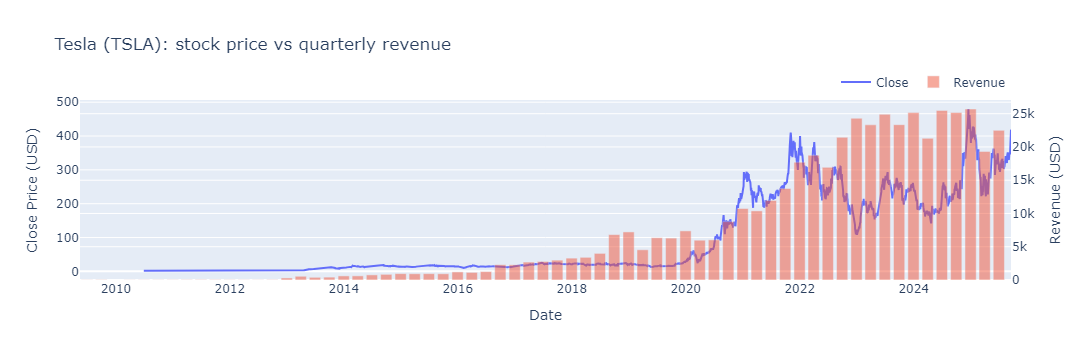

In [17]:
# Plot TSLA's stock vs revenue.
make_graph(tesla_data, tesla_revenue, title="Tesla (TSLA): stock price vs quarterly revenue")

Question 6: Plot the GameStop stock graph

Use the make_graph function to graph the GameStop stock data, also provide a title for the graph.

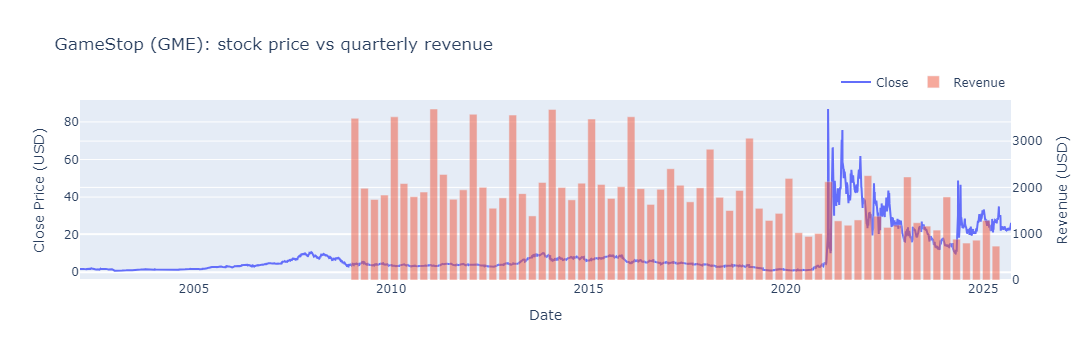

In [19]:
# Plot GME's stock vs revenue.
make_graph(gme_data, gme_revenue, title="GameStop (GME): stock price vs quarterly revenue")